#Long-Short Equity

In [80]:
#if you are using google drive like me
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [81]:
cd "/content/drive/My Drive/go_beyond/project/project_1"

/content/drive/My Drive/go_beyond/project/project_1


In [0]:
#helper file with functions created in stocks returns analysis
%run helper_returns.ipynb

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import math

#remove pandas warning 
import pandas.plotting._converter as pandacnv
pandacnv.register()

##Loading Data 

You can see the analysis of this data in stocks returns file. :)

All funcitions have been explained [here](https://https://nbviewer.jupyter.org/github/victormenuzzo/Quantitative-Analysis/blob/master/part1/stocks_returns.ipynb)

In [0]:
df = pd.read_csv('eod-quotemedia.csv', parse_dates=['date'], index_col=False)
close = df.reset_index().pivot(index='date', columns='ticker', values='adj_close')

#resample daily -> monthly
df_monthly = resample_prices(close)

#raws returns
df_rawRet = compute_rawReturn(df_monthly)

#logs returns 
df_logRet = compute_logReturn(df_monthly)

##Trading Signal

First of all, we need to know what is a trading signal. And [investopedia](https://www.investopedia.com/terms/t/trade-signal.asp) will explain to us: P


>A trade signal is a trigger for action, either to buy or sell a security or other asset, generated by analysis. That analysis can be human generated using technical indicators, or it can be generated using mathematical algorithms based on market action, possibly in combination with other market factors such as economic indicators.


---


We will create a simple trading signal: 
For each month, rank the stocks from the highest to the lowest. 
* Top performing stocks -> Long portfolio
* Bottom performing stocks -> Short portfolio


In [0]:
def top_stocks(df, n):
  df_top = df.copy()
  df_top[:] = 0

  for date, month_return in df.iterrows():
    #nlargest: Return the first n rows ordered by columns in descending order.
    df_top.loc[date, month_return.nlargest(n).index] = 1
  return df_top

In [0]:
#this is our top performing stocks
df_top = top_stocks(df_logRet, 3)

#if we multiply df_monthly by -1 we get bottom performing
df_bottom = top_stocks(df_logRet*-1, 3)

Now we can see our Long and Short portfolio

In [0]:
def show_LongShort(df, n):
  return df.sum().sort_values(ascending=False).index[:n].values.tolist()

In [88]:
print('Top Performing: ')
print(show_LongShort(df_top, 10))

print(20*'-')

print('Bottom Performing: ')
print(show_LongShort(df_bottom, 10))

Top Performing: 
['FCX', 'NFLX', 'AMD', 'MU', 'TRIP', 'EA', 'INCY', 'QRVO', 'COTY', 'SIG']
--------------------
Bottom Performing: 
['CHK', 'FCX', 'NEM', 'WYNN', 'SPLS', 'UAA', 'PXD', 'QRVO', 'M', 'PRGO']


## Checking
This strategy only serves to exemplify a trading signal as it presents some problems. Let's check! :D

In [89]:
print('Number of months: {0}\nNumber of stocks: {1}\n'.format(str(df_top.shape[0]), str(df_top.shape[1])))

Number of months: 47
Number of stocks: 495



First, split our data and rerun top_stocks function to avoid biased data

In [129]:
df_train = df_logRet.loc[:'2016-12-31', :] 

df_top = top_stocks(df_train, 3)
df_bottom = top_stocks(df_train*-1, 3)

print('Top Performing with splitted data: ')
top = show_LongShort(df_top, 5)
print(top)

print(20*'-')

print('Bottom Performing with splitted data: ')
bottom = show_LongShort(df_bottom, 5)
print(bottom)

Top Performing with splitted data: 
['NFLX', 'FCX', 'TRIP', 'INCY', 'AMD']
--------------------
Bottom Performing with splitted data: 
['CHK', 'WYNN', 'FCX', 'NEM', 'SPLS']


Let's test with data from last 6 months present in dataset, we will assume equal weights for each asset

In [134]:
df_test = df_logRet.loc['2017-1-31':, :] 

long_portfolio = df_test[top]
short_portfolio = df_test[bottom]

sum_returns_top = long_portfolio.sum().sum()
sum_returns_bottom = short_portfolio.sum().sum()

print('Log return of top and bottom portfolio: {}'.format(str(sum_returns_top-sum_returns_bottom)))

Log return of top and bottom portfolio: 0.12856637125549888


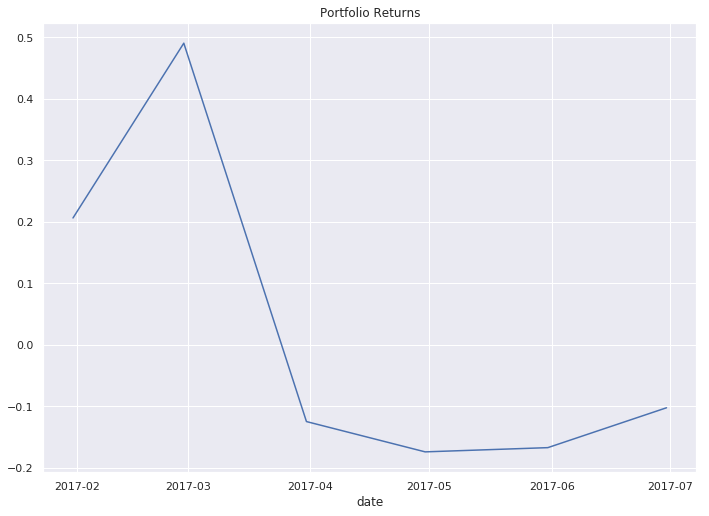

In [141]:
month_return_top = long_portfolio.sum(axis = 1)
month_return_bot = short_portfolio.sum(axis = 1)

month_return_port = month_return_top - month_return_bot

sns.lineplot(month_return_port.index , month_return_port.values)
plt.title('Portfolio Returns')
plt.show()

##Statistical Tests
This plot is very weird. Let's use statistical tests for check a little more

In [0]:
#next steps